<a href="https://colab.research.google.com/github/MatthewBenning/Statistics-Honours-Research-Project/blob/main/multistep_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LSTM for Multistep Forecasting 
# Author: Matthew Benning
# Adapted from Eligijus Bujokas weather forecast framework with multivariate input

import numpy as np 
import pandas as pd 
import random 
import tensorflow as ts
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import itertools
import random

# Neccessary imports for LSTM, Keras package will be used
from tensorflow import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow.keras.callbacks import ModelCheckpoint

# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Statistics Honours Research Project'


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


In [ ]:

# First read in the JSE data set and convert it to a timeseries object
data = pd.read_excel('/content/gdrive/MyDrive/Statistics Honours Research Project/spread_series.xlsx',index_col=0)
data = data.dropna()

# Now we need to train each model individually, so we get series isolated
data_1 = data.iloc[:,0]
data_2 = data.iloc[:,1]
data_3 = data.iloc[:,2]
data_4 = data.iloc[:,3]
data_5 = data.iloc[:,4]




In [ ]:
# Asset Pair 1 LSTM 
# Run everything
#############################################################
# We can adjust these but this is the correct parameter specs for final model

# Number of look back days to use = we use last 365 trading days
lag = 90
# Steps ahead to forecast 
n_ahead = 7
# S30% of the data is in the testing period
test_share = 0.2
# Epochs for training
epochs = 50
# Batch size 
batch_size = 500
# Learning rate
lr = 0.0001
# Number of neurons in LSTM layer
n_layer = 50

# We use the past x days as input
# Create the correct sequential data for LSTM X, Y series
def form_XY(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
   
    # Extracting the number of features that are passed from the array 
    n_features = 1

    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead)])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Run for our spread data
X,Y = form_XY(data_1,lag=365,n_ahead=1,target_index=0)

print(X.shape)
print(Y.shape)

############################################################

# Set up the model class 
# We want an iteractive model training process so we include the 
# TrainCallback function which prevents over fitting once a certain mse reached

class LSTM_spread_forecast():
    
    # Initialize our model class members
    # Have kept the typescript set up as I just learnt it and its nice! MB :D
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, 1))

        
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Init the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compile the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

############################################################################
# Now that model class is initiated we need to scale
# Important that we scale the train and test seperately as to not introduce 
# any look back bias


nrows = data_1.shape[0]
# Spliting into train and test sets
train = data_1[0:int(nrows * (1 -test_share))]
test = data_1[int(nrows * (1 -test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test -train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = form_XY(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = 1

########################################################################
# Scaling done, now we can split the data into the respective subsets

# Train and test splits
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share-0.10))], Y[0:int(X.shape[0] * (1 -test_share-0.10))]
Xval, Yval = X[int(X.shape[0] * (1-test_share)):], Y[int(X.shape[0] * (1 -test_share)):]


# Verify the final shapes, making sure correct set up for LSTM
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)
# Looks good to go!

#####################################################################
# Set up model class for the pair spread

model_pair1 = LSTM_spread_forecast(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=n_ahead,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch_size,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Check the model summary before running
model_pair1.model.summary()
# Training of the model 
history = model_pair1.train()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
for i in range(10):
  for j in range (12):

    # Number of look back days to use = we use last 365 trading days
    lag = 10*(1+i)
    # Steps ahead to forecast 
    n_ahead = 7
    # S30% of the data is in the testing period
    test_share = 0.2
    # Epochs for training
    epochs = 100
    # Batch size 
    batch_size = 500
    # Learning rate
    lr = 0.0001
    # Number of neurons in LSTM layer
    n_layer = 5*(1+j)

    # We use the past x days as input
    # Create the correct sequential data for LSTM X, Y series
    def form_XY(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
      
        # Extracting the number of features that are passed from the array 
        n_features = 1

        # Creating placeholder lists
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag - n_ahead):
                Y.append(ts[(i + lag):(i + lag + n_ahead)])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an RNN input shape 
        X = np.reshape(X, (X.shape[0], lag, n_features))

        return X, Y

    # Run for our spread data
    X,Y = form_XY(data_1,lag=365,n_ahead=1,target_index=0)

    print(X.shape)
    print(Y.shape)

    ############################################################

    # Set up the model class 
    # We want an iteractive model training process so we include the 
    # TrainCallback function which prevents over fitting once a certain mse reached

    class LSTM_spread_forecast():
        
        # Initialize our model class members
        # Have kept the typescript set up as I just learnt it and its nice! MB :D
        def __init__(
            self, 
            X, 
            Y, 
            n_outputs,
            n_lag,
            n_ft,
            n_layer,
            batch,
            epochs, 
            lr,
            Xval=None,
            Yval=None,
            mask_value=-999.0,
            min_delta=0.001,
            patience=5
        ):
            lstm_input = Input(shape=(n_lag, 1))

            
            lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

            x = Dense(n_outputs)(lstm_layer)
            
            self.model = Model(inputs=lstm_input, outputs=x)
            self.batch = batch 
            self.epochs = epochs
            self.n_layer=n_layer
            self.lr = lr 
            self.Xval = Xval
            self.Yval = Yval
            self.X = X
            self.Y = Y
            self.mask_value = mask_value
            self.min_delta = min_delta
            self.patience = patience

        def trainCallback(self):
            return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

        def train(self):
            # Getting the untrained model 
            empty_model = self.model
            
            # Init the optimizer
            optimizer = keras.optimizers.Adam(learning_rate=self.lr)

            # Compile the model
            empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

            if (self.Xval is not None) & (self.Yval is not None):
                history = empty_model.fit(
                    self.X, 
                    self.Y, 
                    epochs=self.epochs, 
                    batch_size=self.batch, 
                    validation_data=(self.Xval, self.Yval), 
                    shuffle=False,
                    callbacks=[self.trainCallback()]
                )
            else:
                history = empty_model.fit(
                    self.X, 
                    self.Y, 
                    epochs=self.epochs, 
                    batch_size=self.batch,
                    shuffle=False,
                    callbacks=[self.trainCallback()]
                )
            
            # Saving to original model attribute in the class
            self.model = empty_model
            
            # Returning the training history
            return history
        
        def predict(self, X):
            return self.model.predict(X)

    ############################################################################
    # Now that model class is initiated we need to scale
    # Important that we scale the train and test seperately as to not introduce 
    # any look back bias


    nrows = data_1.shape[0]
    # Spliting into train and test sets
    train = data_1[0:int(nrows * (1 -test_share))]
    test = data_1[int(nrows * (1 -test_share)):]
    # Scaling the data 
    train_mean = train.mean()
    train_std = train.std()
    train = (train - train_mean) / train_std
    test = (test -train_mean) / train_std
    # Creating the final scaled frame 
    ts_s = pd.concat([train, test])
    # Creating the X and Y for training
    X, Y = form_XY(ts_s.values, lag=lag, n_ahead=n_ahead)
    n_ft = 1

    ########################################################################
    # Scaling done, now we can split the data into the respective subsets

    # Train and test splits
    Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share-0.10))], Y[0:int(X.shape[0] * (1 -test_share-0.10))]
    #Xval, Yval = X[int(X.shape[0] * (1-test_share)):], Y[int(X.shape[0] * (1 -test_share)):]
    Xval, Yval = X[int(X.shape[0] * (1-test_share-0.1)):int(X.shape[0] * (1-test_share))], Y[int(X.shape[0] * (1 -test_share-0.1)):int(X.shape[0] * (1-test_share))]
    Xtest, Ytest = X[int(X.shape[0] * (1-test_share)):], Y[int(X.shape[0] * (1 -test_share)):]


    # Verify the final shapes, making sure correct set up for LSTM
    #print(Xtrain.shape)
    #print(Ytrain.shape)
    #print(Xval.shape)
    #print(Yval.shape)
    # Looks good to go!

    #####################################################################
    # Set up model class for the pair spread

    model_pair1 = LSTM_spread_forecast(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
    )
    # Check the model summary before running
    model_pair1.model.summary()
    # Training of the model 
    history = model_pair1.train()
    cp = ModelCheckpoint('model_pair1', save_best_only = False)


Streaming output truncated to the last 5000 lines.
Total params: 2,882
Trainable params: 2,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 2s 218ms/step - loss: 0.8582 - val_loss: 0.7873
Epoch 2/100
4/4 [==============================] - 1s 160ms/step - loss: 0.8568 - val_loss: 0.7861
Epoch 3/100
4/4 [==============================] - 1s 161ms/step - loss: 0.8555 - val_loss: 0.7849
Epoch 4/100
4/4 [==============================] - 1s 148ms/step - loss: 0.8541 - val_loss: 0.7837
Epoch 5/100
4/4 [==============================] - 1s 147ms/step - loss: 0.8528 - val_loss: 0.7825
Epoch 6/100
4/4 [==============================] - 1s 144ms/step - loss: 0.8514 - val_loss: 0.7813
Epoch 7/100
4/4 [==============================] - 1s 139ms/step - loss: 0.8501 - val_loss: 0.7800
Epoch 8/100
4/4 [==============================] - 1s 147ms/step - loss: 0.8487 - val_loss: 0.7788
Epoch 9/100
4/4 [======

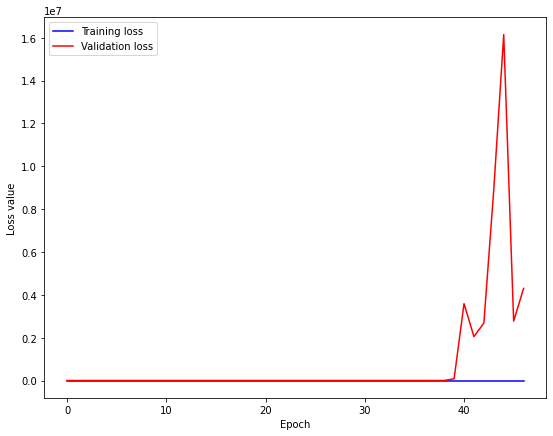

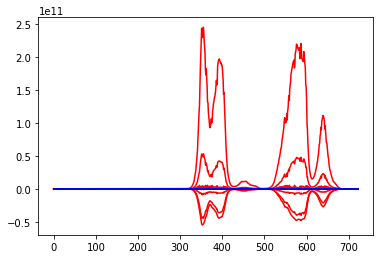

NameError: ignored

In [ ]:
# After model has trained we can now check the results and plot some curves

# Extract the training loss and validation loss
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

# Get the number of epochs that was run before cutting off
n_epochs = range(len(loss))

# Plot the training loss and val loss
plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

# Forecasts against the actual values
forecast = model_pair1.predict(Xval)

# Plot the forecasts
yhat = forecast[1:751,]*train_std +train_mean
y = Yval*train_std +train_mean

plt.plot(yhat,color='red')
plt.plot(y,color='blue')
plt.show()

# Test period 
test_forecast_1= model_pair1.predict(Xtest)
test_forecast_1 = test_forecast_1*test_std+test_mean
plot(test_forecast_1)



In [ ]:
print(train_mean)

8359.024690229215
